In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
load_dataset = False
load_model = False

# Dataset preparing

In [3]:
from dataset.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd

In [4]:
true_dist_size = 10000
dataset = FactDatasetGenerator(number_person=1000,  distribution="zipf", dataset_folder='./dataset/data/', food_list_name="food_list_medium.txt",true_dist_size=true_dist_size, experiment_path="experiment/medium_dataset/data/")

In [5]:
if load_dataset:
    dataset.load_dataset()
    true_dist = dataset.true_dist 
    training_data = dataset.training_data
else:
    # Generate all possible facts
    temp = dataset.generate_all_possibilities()
    # Sample true dist (zipf)
    true_dist = dataset.generate_true_dist()
    # Sample training data uniformly, %80 of true dist
    training_dataset_size = int(0.8 * true_dist_size)
    training_data = dataset.sample_training_data(training_dataset_size,true_dist.tolist())

In [6]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [7]:
true_dist_df

,facts
0,"Valerie,stuffed shells"
1,"Innis,shepherd's pie"
2,"Cleon,jambalaya"
3,"Ramon,focaccia"
4,"Lesley,turnover"
...,...
9995,"Zeb,aloo gobi"
9996,"Ali,scallops"
9997,"Ambrose,chocolate cake"
9998,"Bernie,fish and chips"


In [8]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count_true')


In [9]:
true_duplicates_count

,facts,count_true
0,"Abbe,cheesecake",1
1,"Abbe,quiche lorraine",1
2,"Abbe,rack of lamb",1
3,"Abbe,spring rolls",1
4,"Abbe,turkey sandwich",1
...,...,...
4781,"Zita,enchiladas",1
4782,"Zorine,donuts",1
4783,"Zorine,fondue",2
4784,"Zorine,tacos",1


In [10]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count_train')

In [11]:
training_duplicates_count

,facts,count_train
0,"Abbe,cheesecake",1
1,"Abbe,quiche lorraine",1
2,"Abbe,rack of lamb",1
3,"Abbe,spring rolls",1
4,"Abbe,turkey sandwich",1
...,...,...
3952,"Zita,enchiladas",1
3953,"Zorine,donuts",1
3954,"Zorine,fondue",2
3955,"Zorine,tacos",1


In [12]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [13]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [14]:
## import mingpt
sys.path.append('minGPT/')
from mingpt.model import GPT
from mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 2

# model_config.model_type = 'gpt-nano'
# model_config.vocab_size = dataset.vocab_size
# model_config.block_size = 2

model = GPT(model_config).to("cuda")

number of parameters: 38.49M


In [15]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [16]:
best_iter = 100000000000000
best_epoch = 0
def batch_end_callback(trainer):
    global best_iter
    global best_epoch
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 100:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        if trainer.loss.item() < best_iter:
            best_iter = trainer.loss.item()
            best_epoch = trainer.iter_num
            torch.save(model.state_dict(), dataset.experiment_path[:-5] + "model.pt")
trainer.set_callback('on_batch_end', batch_end_callback)

if load_model:
    model.load_state_dict(torch.load("experiment/model.pt"))
else:
    trainer.run()
    print(f"Best loss is: {best_iter} on epoch: {best_epoch}")

C:\Users\leonp\AppData\Local\Temp\ipykernel_27720\3675710179.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
C:\Users\leonp\AppData\Local\Temp\ipykernel_27720\3675710179.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 0.00ms; iter 0: train loss 7.20206
iter_dt 3.87ms; iter 100: train loss 5.27940
iter_dt 3.95ms; iter 200: train loss 4.70217
iter_dt 3.82ms; iter 300: train loss 4.81741
iter_dt 3.81ms; iter 400: train loss 4.82538
iter_dt 3.87ms; iter 500: train loss 4.47827
iter_dt 3.87ms; iter 600: train loss 4.18192
iter_dt 3.82ms; iter 700: train loss 4.50371
iter_dt 3.92ms; iter 800: train loss 4.32867
iter_dt 3.98ms; iter 900: train loss 3.96061
iter_dt 3.92ms; iter 1000: train loss 3.94050
iter_dt 3.81ms; iter 1100: train loss 4.05001
iter_dt 3.92ms; iter 1200: train loss 4.35513
iter_dt 3.78ms; iter 1300: train loss 4.38618
iter_dt 4.01ms; iter 1400: train loss 3.77079
iter_dt 3.94ms; iter 1500: train loss 4.29178
iter_dt 3.98ms; iter 1600: train loss 4.38071
iter_dt 3.85ms; iter 1700: train loss 3.93722
iter_dt 3.81ms; iter 1800: train loss 3.86404
iter_dt 3.91ms; iter 1900: train loss 4.27257
iter_dt 3.91ms; iter 2000: train loss 4.21830
iter_dt 3.86ms; iter 2100: train loss 4.20365


In [17]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(1297, 512)
    (wpe): Embedding(2, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_f

# Generate unconditioned facts

In [18]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [19]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to("cuda")
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [20]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [21]:
collected_generations_counts = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [22]:
collected_generations_counts

,facts,count_generated
0,"Abbi,tempura",1
1,"Abbot,honey cake",1
2,"Abbot,souffle",1
3,"Abdul,Tiffany",1
4,"Abdul,eggs florentine",1
...,...,...
597,"rabbit stew,monkey bread",1
598,"sashimi,Eduardo",1
599,"soup dumplings,Melicent",1
600,"spinach dip,Debi",1


In [23]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer')

In [24]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, collected_generations_counts, on='facts', how='outer')

In [25]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Abbe,cheesecake",1.0,1.0,NaN
1,"Abbe,quiche lorraine",1.0,1.0,NaN
2,"Abbe,rack of lamb",1.0,1.0,NaN
3,"Abbe,spring rolls",1.0,1.0,NaN
4,"Abbe,turkey sandwich",1.0,1.0,NaN
...,...,...,...,...
4882,"rabbit stew,monkey bread",NaN,NaN,1.0
4883,"sashimi,Eduardo",NaN,NaN,1.0
4884,"soup dumplings,Melicent",NaN,NaN,1.0
4885,"spinach dip,Debi",NaN,NaN,1.0


In [26]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [27]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/len(true_dist)


In [28]:
comparison_df = comparison_df.sort_values(by=['count_generated'], ascending=False)

In [29]:
comparison_df

,facts,count_true,count_train,count_generated
617,"Brianna,takoyaki",0.0783,0.079250,0.083
427,"Barry,stuffed shells",0.0383,0.038125,0.045
4092,"Sharlene,naan bread",0.0266,0.027125,0.032
2774,"Lesley,turnover",0.0177,0.017000,0.021
163,"Allx,eggs benedict",0.0052,0.005500,0.013
...,...,...,...,...
1723,"Fredericka,scallops",0.0001,0.000125,0.000
1724,"Fredrika,macaroni and cheese",0.0002,0.000250,0.000
1725,"Fredrika,neapolitan pizza",0.0001,0.000000,0.000
1727,"Fredrika,thai iced tea",0.0001,0.000125,0.000


In [30]:
comparison_df.sum()

facts              Brianna,takoyakiBarry,stuffed shellsSharlene,n...
count_true                                                       1.0
count_train                                                      1.0
count_generated                                                  1.0
dtype: object

<Axes: >

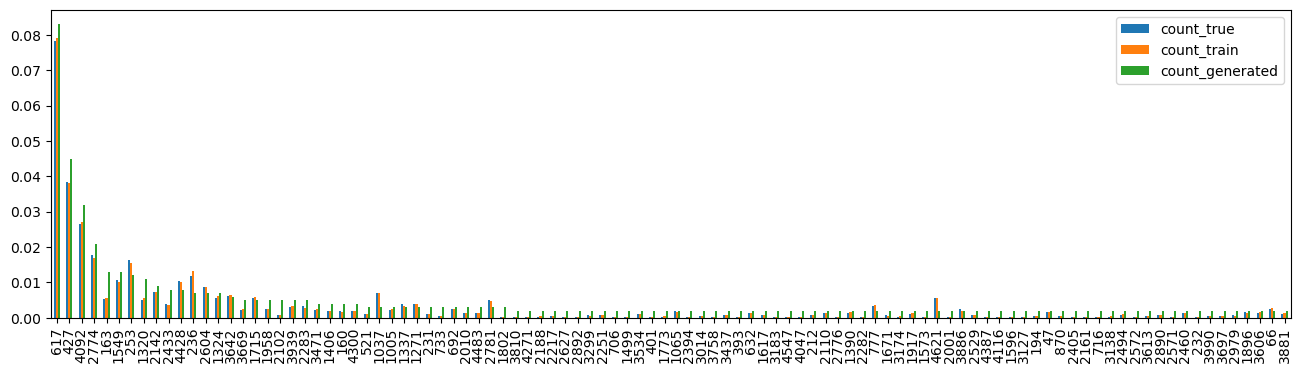

In [31]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))

## Hallucination rates

In [32]:
# True hallucination rate (generations not in true dist)
true_hallucinations = pd.merge(collected_generations_counts, true_duplicates_count, on='facts', how='left')


In [33]:
true_hallucinations

,facts,count_generated,count_true
0,"Abbi,tempura",1,1.0
1,"Abbot,honey cake",1,2.0
2,"Abbot,souffle",1,2.0
3,"Abdul,Tiffany",1,NaN
4,"Abdul,eggs florentine",1,1.0
...,...,...,...
597,"rabbit stew,monkey bread",1,NaN
598,"sashimi,Eduardo",1,NaN
599,"soup dumplings,Melicent",1,NaN
600,"spinach dip,Debi",1,NaN


In [34]:
true_hallucinations = true_hallucinations.fillna(0)
number_of_true_hallucinations =true_hallucinations["count_true"].value_counts()[0]
true_hallucinations_rate = number_of_true_hallucinations / len(collected_generations)
print(f"Rate of true hallucinations: {true_hallucinations_rate} ")

Rate of true hallucinations: 0.101 


In [35]:
# Naive hallucination rate (every generation not in training data)
naive_hallucinations = pd.merge(collected_generations_counts, training_duplicates_count, on='facts', how='left')

In [36]:
naive_hallucinations

,facts,count_generated,count_train
0,"Abbi,tempura",1,1.0
1,"Abbot,honey cake",1,1.0
2,"Abbot,souffle",1,2.0
3,"Abdul,Tiffany",1,NaN
4,"Abdul,eggs florentine",1,1.0
...,...,...,...
597,"rabbit stew,monkey bread",1,NaN
598,"sashimi,Eduardo",1,NaN
599,"soup dumplings,Melicent",1,NaN
600,"spinach dip,Debi",1,NaN


In [37]:
naive_hallucinations = naive_hallucinations.fillna(0)
number_of_naive_hallucinations = naive_hallucinations["count_train"].value_counts()[0]
naive_hallucinations_rate = number_of_naive_hallucinations / len(collected_generations)
print(f"Rate of naive hallucinations: {naive_hallucinations_rate} ")

Rate of naive hallucinations: 0.101 


### Monofact rate

In [38]:
training_duplicates_count["count_train"].value_counts()[1] / len(training_data)

0.41975

In [39]:
training_duplicates_count["count_train"].value_counts()[1]

3358

### Miscalibration

In [40]:
from lib.calibration import miscalibration

In [41]:
comparison_sorted_by_generated = comparison_df.sort_values(by='count_generated', ascending=False)

In [42]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_true'])

Adaptive binning with 12 bins
bin with g_proba / p_proba 0.083 0.0783
bin with g_proba / p_proba 0.077 0.0649
bin with g_proba / p_proba 0.07899999999999999 0.0622
bin with g_proba / p_proba 0.081 0.0676
bin with g_proba / p_proba 0.08200000000000003 0.042800000000000005
bin with g_proba / p_proba 0.08200000000000006 0.033
bin with g_proba / p_proba 0.08300000000000006 0.022200000000000004
bin with g_proba / p_proba 0.08300000000000006 0.0157
bin with g_proba / p_proba 0.08300000000000006 0.0104
bin with g_proba / p_proba 0.08300000000000006 0.016799999999999995
bin with g_proba / p_proba 0.08300000000000006 0.020399999999999998
bin with g_proba / p_proba 0.08300000000000006 0.0159
bin with g_proba / p_proba 0.01800000000000001 0.5498000000000001


0.5509739257218109

In [43]:
miscalibration(comparison_sorted_by_generated['count_generated'], comparison_sorted_by_generated['count_train'])

Adaptive binning with 12 bins
bin with g_proba / p_proba 0.083 0.07925
bin with g_proba / p_proba 0.077 0.06525
bin with g_proba / p_proba 0.07899999999999999 0.06125
bin with g_proba / p_proba 0.081 0.07
bin with g_proba / p_proba 0.08200000000000003 0.042499999999999996
bin with g_proba / p_proba 0.08200000000000006 0.03325
bin with g_proba / p_proba 0.08300000000000006 0.024
bin with g_proba / p_proba 0.08300000000000006 0.016125
bin with g_proba / p_proba 0.08300000000000006 0.010875000000000001
bin with g_proba / p_proba 0.08300000000000006 0.018250000000000002
bin with g_proba / p_proba 0.08300000000000006 0.022500000000000006
bin with g_proba / p_proba 0.08300000000000006 0.01725
bin with g_proba / p_proba 0.01800000000000001 0.5395000000000001


0.5410765357502518

### Check if it holds

In [44]:
unique_names = len(set([t[1] for t in train_dataset]))
unique_foods = len(set([t[2] for t in train_dataset]))
# Possible generations
POSS_GENERATIONS = unique_names * unique_foods

# Facts to all possibilities - facts, approximated
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS = 300 * len(training_duplicates_count) / (POSS_GENERATIONS - len(training_duplicates_count))

In [45]:
HALLUCINATION_RATE = 0.134

MF = 0.43875

MISCALIBRATION = 0.2891

In [46]:
APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.018549584386022118

In [47]:
MF - MISCALIBRATION

0.14964999999999995

In [48]:
7 / np.sqrt(len(training_data))

0.07826237921249264

In [49]:
MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

0.05283803640148519

In [50]:
HALLUCINATION_RATE

0.134

In [51]:
HALLUCINATION_RATE > MF - MISCALIBRATION

False

In [52]:
HALLUCINATION_RATE > MF - MISCALIBRATION - (7 / np.sqrt(len(training_data))) - APPROX_FACTS_TO_POSSIBLE_HALLUCINATIONS

True